In [1]:
import gymnasium as gym
from twsbr_env.envs import TwsbrEnv
import numpy as np
import matplotlib.pyplot as plt

# PID Controller
class PIDController:
    def __init__(self, kp, ki, kd, dt, max_speed):
        self.kp = kp * max_speed
        self.ki = ki * max_speed
        self.kd = kd * max_speed
        self.dt = dt
        self.integral = 0.0
        self.prev_error = 0.0
    
    def compute(self, error):
        self.integral += error * self.dt
        derivative = (error - self.prev_error) / self.dt
        self.prev_error = error
        return (self.kp * error) + (self.ki * self.integral) + (self.kd * derivative)

# Initialize environment
env = gym.make("TwsbrEnv-v0", render_mode="human", action_type="continuous")
obs, info = env.reset()

dt = 1.0 / 50.0
max_speed = 255.0
balance_pid = PIDController(kp=0.01, ki=0.05, kd=0.00001, dt=dt, max_speed=max_speed)

# Simulation parameters
sim_duration = 30  # seconds
steps = int(sim_duration / dt)
time_list, balance_target_list, balance_current_list, balance_output_list = [], [], [], []
acc_reward = 0

for step in range(steps):
    time_list.append(step * dt)
    balance_target = 0.0  # Upright position
    current_angle = obs[2]
    balance_output = -balance_pid.compute(balance_target - current_angle)
    balance_output = np.clip(balance_output, -1.0, 1.0)
    
    # Store data
    balance_target_list.append(balance_target)
    balance_current_list.append(current_angle)
    balance_output_list.append(balance_output)
    
    # Apply action
    action = np.array([balance_output, balance_output])
    obs, reward, terminated, truncated, info = env.step(action)
    acc_reward += reward
    
    if terminated:
        print(f"terminated: {terminated}, truncated: {truncated}")
        obs, info = env.reset()
    env.render()

print(f"REWARD: {acc_reward}")
env.close()

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(time_list, balance_target_list, label="Target", color='b')

plt.plot(time_list, balance_output_list, label="PID Output", color='g')

plt.plot(time_list, balance_current_list, label="Current", color='r')
plt.ylim(-0.25, 0.25)
plt.xlabel("Time (s)")
plt.ylabel("Balance Angle")
plt.legend()
plt.grid()
plt.title("Self-Balancing PID Response")
plt.show()


: 

In [ ]:
# main.py
import gymnasium as gym
from twsbr_env.envs import TwsbrEnv
import numpy as np

# Initialize the environment
env = gym.make(
    "TwsbrEnv-v0",
    render_mode="human",
    action_type="continuous"
)

# pid_controller.py
class PIDController:
    def __init__(self, kp, ki, kd, dt, max_speed):
        self.kp = round(kp, 4) * max_speed
        self.ki = round(ki, 4) * max_speed
        self.kd = round(kd, 4) * max_speed
        self.dt = dt

        self.integral = 0.0
        self.prev_error = 0.0

    def compute(self, current_value, target_value):
        error = target_value - current_value
        self.integral += error * self.dt
        derivative = (error - self.prev_error) / self.dt
        self.prev_error = error

        output = (self.kp * error) + (self.ki * self.integral) + (self.kd * derivative)
        return output

# utils.py
import numpy as np

def mps_to_radps(mps):
    """Converts linear velocity (m/s) to angular velocity (rad/s) for a wheel radius of 4.5 cm."""
    return mps / 0.045  # Wheel radius = 4.5 cm

# plot_results.py
import matplotlib.pyplot as plt

def plot_pid_results(time_list, data_dict, additional_data=None):
    """Plots PID results and actions separately."""
    # Plot PID outputs
    plt.figure(figsize=(20, 15))
    for idx, (title, pid_data) in enumerate(data_dict.items()):
        target = pid_data['target']
        current = pid_data['current']
        error = pid_data['error']
        
        plt.subplot(len(data_dict), 1, idx + 1)
        plt.plot(time_list, target, label=f"{title} Target", color='r')
        plt.plot(time_list, current, label=f"{title} Current", color='b')
        plt.plot(time_list, error, label=f"{title} Error", color='y')
        plt.title(f"{title} PID Outputs")
        plt.xlabel("Time (s)")
        plt.ylabel("Value")
        plt.legend()
        plt.grid()
    plt.tight_layout()
    plt.show()

    # Plot actions separately
    # Plot actions separately
    if additional_data:
        # Plot PID Outputs (3 parameters)
        plt.figure(figsize=(20, 10))
        plt.subplot(2, 1, 1)  # First subplot for PID outputs
        plt.title("PID Outputs")
        colors = ['yellow', 'black', 'blue']  # Daftar warna untuk PID outputs
        labels = ['velocity_output', 'balance_output', 'steer_output']
        for label, color in zip(labels, colors):
            plt.plot(time_list, additional_data[label], label=label, color=color)
        plt.xlabel("Time (s)")
        plt.ylabel("PID Outputs")
        plt.legend()
        plt.grid()

        # Plot Actions (2 parameters)
        plt.subplot(2, 1, 2)  # Second subplot for actions
        plt.title("Wheel Actions")
        action_colors = ['red', 'blue']  # Daftar warna untuk actions
        action_labels = ['left_action', 'right_action']
        for label, color in zip(action_labels, action_colors):
            plt.plot(time_list, additional_data[label], label=label, color=color)
        plt.xlabel("Time (s)")
        plt.ylabel("Action Values")
        plt.legend()
        plt.grid()

        # Adjust layout and show
        plt.tight_layout()
        plt.show()

# PID Controllers
max_speed = 255.0
dt = 1.0 / 100.0
velocity_pid = PIDController(kp=0.01, ki=0.0, kd=0.0000, dt=dt, max_speed=max_speed)
balance_pid = PIDController(kp=0.0125, ki=0.5, kd=0.00005, dt=dt, max_speed=max_speed)
steer_pid = PIDController(kp=0.004, ki=0.00, kd=0.008, dt=dt, max_speed=max_speed)

# Simulation settings
sim_duration = 5
steps = int(sim_duration / dt)  
time_list = []

# Data storage
data_dict = {
    'velocity': {'target': [], 'current': [], 'error': []},
    'balance': {'target': [], 'current': [], 'error': []},
    'steer': {'target': [], 'current': [], 'error': []}
}

# Additional data storage for PID outputs and actions
additional_data = {
    'velocity_output': [],
    'balance_output': [],
    'steer_output': [],
    'left_action': [],
    'right_action': []
}

obs, info = env.reset()
acc_reward = 0

for step in range(steps):
    current_time = step * dt
    time_list.append(current_time)

    # Velocity PID
    velocity_target = 0.2
    current_velocity = obs[4]
    velocity_output = velocity_pid.compute(current_velocity, velocity_target)
    velocity_output = np.clip(velocity_output, -0.05 , 0.05)
    # Balance PID
    balance_target = 0.025 #velocity_output
    current_angle = obs[2]
    balance_output = -balance_pid.compute(current_angle, balance_target)

    # Steer PID
    steer_target = 0.0
    current_line_position = obs[3]
    steer_output = steer_pid.compute(current_line_position, steer_target)

    # Store data
    for key, (target_val, current_val, error_val) in zip(
    data_dict.keys(),
    [(velocity_target, current_velocity, velocity_target - current_velocity),
     (balance_target, current_angle, balance_target - current_angle),
     (steer_target, current_line_position, steer_target - current_line_position)]
    ):
        data_dict[key]['target'].append(target_val)
        data_dict[key]['current'].append(current_val)
        data_dict[key]['error'].append(error_val)

    # Combine outputs for wheel commands
    left_wheel_command = balance_output + steer_output
    right_wheel_command = balance_output - steer_output

    # Normalize wheel commands to range [-1, 1]
    left_wheel_normalized = np.clip(left_wheel_command, -1.0, 1.0)
    right_wheel_normalized = np.clip(right_wheel_command, -1.0, 1.0)

    # Store additional data
    additional_data['velocity_output'].append(velocity_output)
    additional_data['balance_output'].append(balance_output)
    additional_data['steer_output'].append(steer_output)
    additional_data['left_action'].append(left_wheel_normalized)
    additional_data['right_action'].append(right_wheel_normalized)

    # Take action
    #action = np.array([left_wheel_normalized, right_wheel_normalized])
    action = np.array([0.1, 0.1])
    
    obs, reward, done, truncated, info = env.step(action)
    acc_reward += reward

    if done or truncated:
        obs, info = env.reset()

    env.render()

print(f"REWARD: {acc_reward}")
env.close()

# Plot results
plot_pid_results(time_list, data_dict, additional_data)


In [2]:
import math

# Given rad/s value
radps = 255

# Convert rad/s to RPS
rps = radps / (2 * math.pi)
rps

40.58451048843331

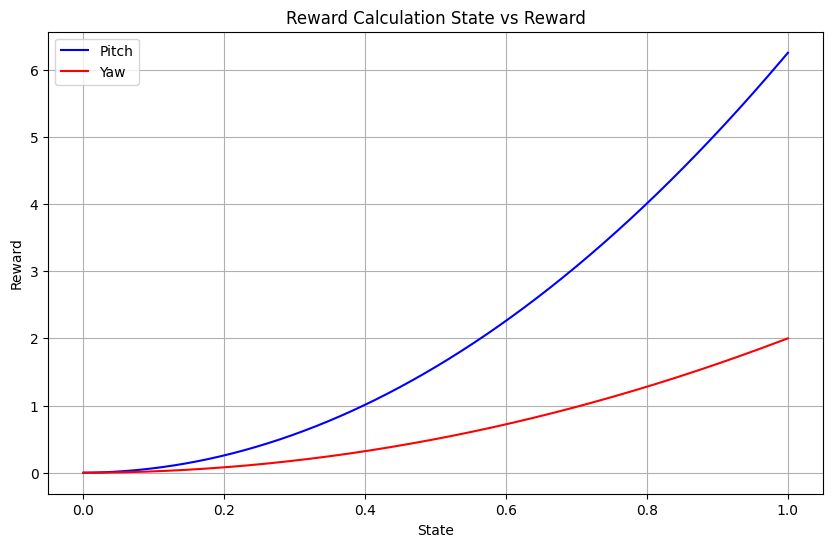

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Generate the data points
x = np.linspace(0.0001, 1., 1000)
pitch_data = np.linspace(0.001, 0.25, 1000)
yaw_data = np.linspace(0.001, 1., 1000)

pitch = ((pitch_data) ** 2) * 100# x squared
yaw = ((yaw_data) ** 2) * 2
 # 2 raised to the power of x

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(x, pitch, label="Pitch", color="blue")
plt.plot(x, yaw, label="Yaw", color="red")

# Add labels, title, legend, and grid
plt.title("Reward Calculation State vs Reward")
plt.xlabel("State")
plt.ylabel("Reward")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


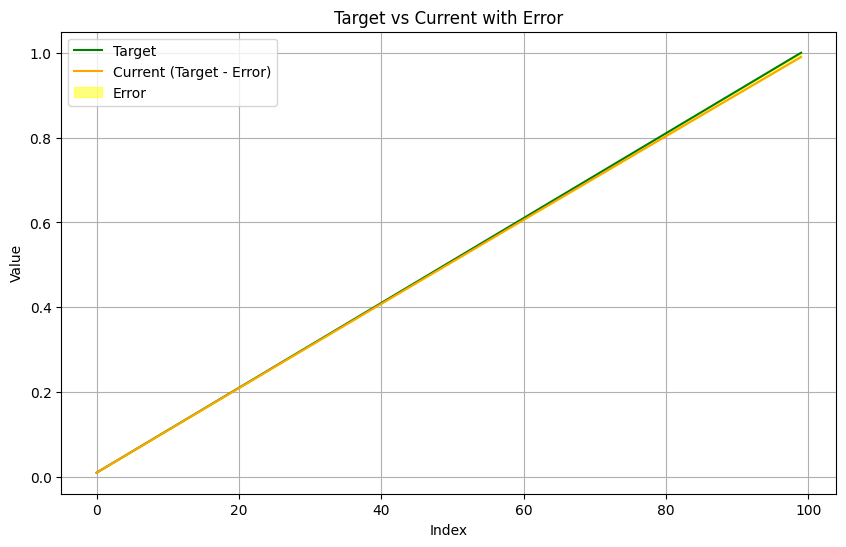

In [13]:
# Re-import necessary libraries after reset
import numpy as np
import matplotlib.pyplot as plt

# Generate the data points
target = np.linspace(0.01, 1.0, 100)  # Target values
error = np.linspace(0.01, 0.1, 100)  # Error values

# Calculate the current values (target - error)
current = target - error ** 2

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(target, label="Target", color="green")
plt.plot(current, label="Current (Target - Error)", color="orange")
plt.fill_between(range(len(target)), current, target, color="yellow", alpha=0.5, label="Error")

# Add labels, title, legend, and grid
plt.title("Target vs Current with Error")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [16]:
pitch, yaw, left_speed, right_speed = 0.075, 0.25, 0.01, -0.01
target_speed = 0.01

speed = (left_speed + right_speed) / 2

reward = 0

# Reward  or penalty by pitch and yaw stability
reward1 = 0.5 - abs(pitch*10)**2
reward2 = 1.0 - ((abs(yaw *10)**2) / 20 )

error_left_speed = target_speed - left_speed
error_right_speed = target_speed - right_speed

reward3 = 1.0 - (abs(error_left_speed - error_right_speed) * 100)
reward4 = 1.0 - (abs(target_speed - speed) * 100)

print(f"\n reward pitch: {reward1},\n reward yaw: {reward2}")
print(f"\n reward wheels {reward3}")
print(f"\n reward speed {reward4}")

#error_speed = target_speed - speed
#error_left_speed = target_speed - left_speed
#error_right_speed = target_speed - right_speed
#
#print(f"\ntarget_speed : {target_speed}, \n speed: {speed}, \n error_speed: {error_speed}, \n error_left_speed: {error_left_speed}, \n error_right_speed: {error_right_speed}")
#
#print(f"target_speed - error_speed: {target_speed - error_speed}")
#print(f"target_speed - error_left_speed: {target_speed - error_left_speed}")
#print(f"target_speed - error_right_speed: {target_speed - error_right_speed}")
#
## Penalize large deviations from target values        
##reward += abs(error_speed)**2 
##reward += -1 if left_speed < (self.target_speed * 50) else -abs(error_left_speed )**2 
##reward += -1 if right_speed < (self.target_speed * 50) else -abs(error_right_speed)**  
#
#
##penalties for diferential on wheels
#reward10 = (left_speed - right_speed) * 10
#print(f"\n differential : {reward10}")
#
##reward mean speed
#reward4 = (target_speed - abs(error_left_speed)) * 10 if left_speed >= (target_speed * 0.5) else -abs(target_speed - abs(error_left_speed)) * 10 
#reward5 = (target_speed - abs(error_right_speed)) * 10 if right_speed >= (target_speed * 0.5) else -abs(target_speed - abs(error_right_speed)) * 10 
#
#reward9 = (reward4 + reward5)/2
#print(f"{reward3} \n {reward4} \n {reward5}")
#print(f"\n reward/penalti speed : {reward9}")

print(f"\ntotal reward : {(reward1+reward2+reward3+reward4)}")



 reward pitch: -0.0625,
 reward yaw: 0.6875

 reward wheels -1.0

 reward speed 0.0

total reward : -0.375


In [64]:
# Input parameter untuk observasi
pitch = 0.01
yaw = 0.1
linear_speed = 0.0359
linear_left_wheel = 0.359
linear_right_wheel = 0.159
left_wheel_revolutions = 0.002
right_wheel_revolutions = 0.002

prev_pitch = 0.0
prev_yaw = 0.0
prev_linear_speed = 0.0
prev_linear_left_wheel = 0.0
prev_linear_right_wheel = 0.0
prev_left_wheel_revolutions = 0.0
prev_right_wheel_revolutions = 0.0

# Parameter fungsi reward
target_revolutions = 1.0
target_pitch = 0.05  # 9 degree
target_speed = 0.05  # 0.5 m/s
speed_penalty_factor = 3.0
pitch_penalty_factor = 3.0
yaw_penalty_factor = 3.0


current_revolutions = (left_wheel_revolutions + right_wheel_revolutions) / 2
previous_revolutions = (prev_left_wheel_revolutions + prev_right_wheel_revolutions) / 2

differential_wheels_speed =  (linear_left_wheel - linear_right_wheel)
differential_wheels_revolution = (left_wheel_revolutions - right_wheel_revolutions)

        # Perhitungan reward
reward = 0.0
# Insentif bertahan lama
reward += 0.5


reward -= ((abs(pitch * 10) **2)) * 0.25
reward -= ((abs(yaw * 10) **2)/10) * 0.25
reward -= (target_revolutions - current_revolutions) * 0.5

reward, target_revolutions, current_revolutions


(-0.026500000000000024, 1.0, 0.002)

In [3]:
# -------------------------------------------------------------
# Inferensi dan evaluasi dengan custom evaluasi metrik
# -------------------------------------------------------------
import numpy as np  # Tambahkan numpy untuk analisis statistik
import gymnasium as gym
from twsbr_env.envs import TwsbrEnv  # Import environment
from stable_baselines3 import SAC
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import CheckpointCallback
# Muat kembali lingkungan dan model
env = gym.make("TwsbrEnv-v0",
               render_mode="human",
               action_type="continuous"  # Action type
               )
model = SAC.load("./models/sac_checkpoint_15000_steps")
#model = SAC.load("sac_tws_v10")
# Mulai evaluasi
total_rewards = []
episode_lengths = []
episode_reward = 0
episode_length = 0

obs, info = env.reset()
terminated = False
truncated = False

for _ in range(10000):  # Jumlah langkah yang akan dilakukan selama evaluasi
    # Pilih tindakan berdasarkan model
    action, _states = model.predict(obs, deterministic=True)

    # Lakukan aksi di lingkungan
    obs, reward, terminated, truncated, info = env.step(action)
    
    episode_reward += reward
    episode_length += 1

    # Render visualisasi (jika diinginkan)
    # Reset episode jika selesai
    if terminated or truncated:
        #print(f"\r {obs}", end="")
        total_rewards.append(episode_reward)
        episode_lengths.append(episode_length)
        obs, info = env.reset()
        episode_reward = 0
        episode_length = 0

# Analisis hasil evaluasi
average_reward = np.mean(total_rewards)
average_length = np.mean(episode_lengths)

print(f"Average Reward per Episode: {average_reward:.2f}")
print(f"Average Episode Length: {average_length:.2f}")

# Menutup lingkungan
env.close()

Pitch: 0.0033, Yaw: 0.1250, Linear Speed: 0.0790, Linear Left Wheel: 0.0582, Linear Right Wheel: 0.0998, Left Wheel Revolutions: 0.0001, Right Wheel Revolutions: 0.0001, Previous Pitch: 0.0033, Previous Yaw: 0.1250, Previous Linear Speed: 0.0790, Previous Linear Left Wheel: 0.0582, Previous Linear Right Wheel: 0.0998, Previous Left Wheel Revolutions: 0.0001, Previous Right Wheel Revolutions: 0.0001
Pitch: -0.0033, Yaw: 0.0000, Linear Speed: 0.0129, Linear Left Wheel: -0.0707, Linear Right Wheel: 0.0965, Left Wheel Revolutions: -0.0000, Right Wheel Revolutions: 0.0002, Previous Pitch: -0.0033, Previous Yaw: 0.0000, Previous Linear Speed: 0.0129, Previous Linear Left Wheel: -0.0707, Previous Linear Right Wheel: 0.0965, Previous Left Wheel Revolutions: -0.0000, Previous Right Wheel Revolutions: 0.0002
Pitch: -0.0038, Yaw: 0.0000, Linear Speed: -0.0218, Linear Left Wheel: -0.1347, Linear Right Wheel: 0.0910, Left Wheel Revolutions: -0.0001, Right Wheel Revolutions: 0.0003, Previous Pitch: 

error: Not connected to physics server.

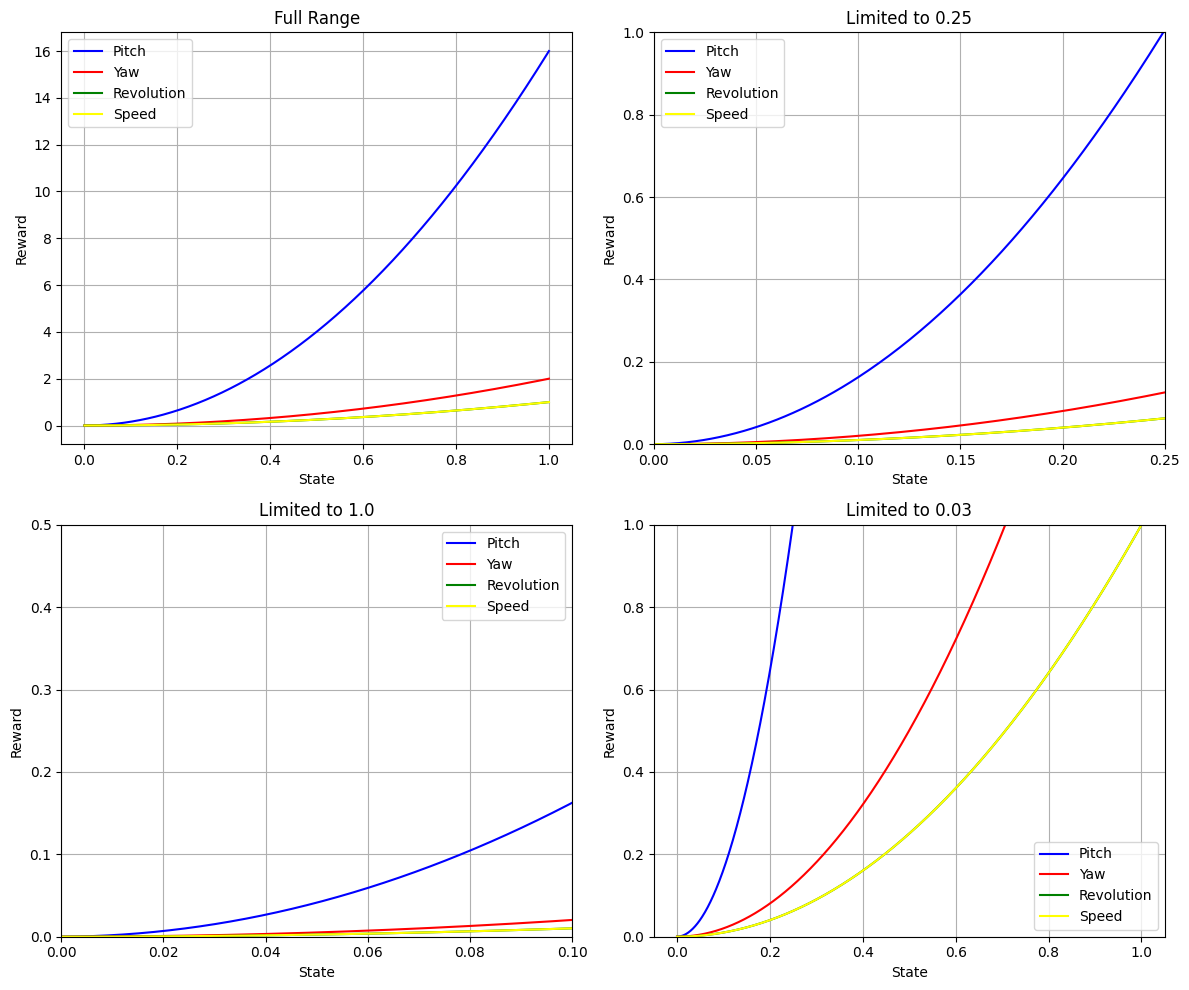

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Generate the data points
x = np.linspace(0.0001, 1.0, 1000)
pitch_data = np.linspace(0.001, 1.00, 1000)
yaw_data = np.linspace(0.001, 1.0, 1000)
revolution_data = np.linspace(0.001, 1.00, 1000)
speed_data = np.linspace(0.001, 1., 1000)

pitch = (pitch_data **2) * 16
yaw = (yaw_data ** 2) * 2
revolution = (revolution_data ** 2)
speed = (revolution_data ** 2)

# Create multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Full range
axes[0, 0].plot(x, pitch, label="Pitch", color="blue")
axes[0, 0].plot(x, yaw, label="Yaw", color="red")
axes[0, 0].plot(x, revolution, label="Revolution", color="green")
axes[0, 0].plot(x, speed, label="Speed", color="yellow")

axes[0, 0].set_title("Full Range")
axes[0, 0].set_xlabel("State")
axes[0, 0].set_ylabel("Reward")
axes[0, 0].legend()
axes[0, 0].grid(True)

# Plot 2: Limited to 0.25
axes[0, 1].plot(x, pitch, label="Pitch", color="blue")
axes[0, 1].plot(x, yaw, label="Yaw", color="red")
axes[0, 1].plot(x, revolution, label="Revolution", color="green")
axes[0, 1].plot(x, speed, label="Speed", color="yellow")

axes[0, 1].set_xlim(0, 0.25)
axes[0, 1].set_ylim(0, 1)
axes[0, 1].set_title("Limited to 0.25")
axes[0, 1].set_xlabel("State")
axes[0, 1].set_ylabel("Reward")
axes[0, 1].legend()
axes[0, 1].grid(True)

# Plot 3: Limited to 1.0
axes[1, 0].plot(x, pitch, label="Pitch", color="blue")
axes[1, 0].plot(x, yaw, label="Yaw", color="red")
axes[1, 0].plot(x, revolution, label="Revolution", color="green")
axes[1, 0].plot(x, speed, label="Speed", color="yellow")

axes[1, 0].set_xlim(0, 0.1)
axes[1, 0].set_ylim(0, 0.5)
axes[1, 0].set_title("Limited to 1.0")
axes[1, 0].set_xlabel("State")
axes[1, 0].set_ylabel("Reward")
axes[1, 0].legend()
axes[1, 0].grid(True)

# Plot 4: Log scale for better visualization
axes[1, 1].plot(x, pitch, label="Pitch", color="blue")
axes[1, 1].plot(x, yaw, label="Yaw", color="red")
axes[1, 1].plot(x, revolution, label="Revolution", color="green")
axes[1, 1].plot(x, speed, label="Speed", color="yellow")

#axes[1, 1].set_xlim(0, 0.025)
axes[1, 1].set_ylim(0, 1.0)
axes[1, 1].set_title("Limited to 0.03")
axes[1, 1].set_xlabel("State")
axes[1, 1].set_ylabel("Reward")
axes[1, 1].legend()
axes[1, 1].grid(True)

# Adjust layout and show plot
plt.tight_layout()
plt.show()


In [9]:
import numpy as np

discrete_velocity = np.linspace(-255, 255, num=21)
discrete_velocity

array([-255. , -229.5, -204. , -178.5, -153. , -127.5, -102. ,  -76.5,
        -51. ,  -25.5,    0. ,   25.5,   51. ,   76.5,  102. ,  127.5,
        153. ,  178.5,  204. ,  229.5,  255. ])

In [3]:
!pip install pyswarm

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pyswarm: filename=pyswarm-0.6-py3-none-any.whl size=4486 sha256=9e03ec5ed0c7919d9c2437bc7fc0b52a8ff6d465481ed019223b0415e80c9557
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\71\67\40\62fa158f497f942277cbab8199b05cb61c571ab324e67ad0d6
Successfully built pyswarm


In [9]:
import numpy as np
from pyswarm import pso

# Simulasi Forward Kinematics (FK) sederhana
def forward_kinematics(joint_angles):
    """Menghitung posisi end-effector dari sudut joint"""
    L = [90, 90, 40]  # Panjang link (sesuai dengan yang kamu gunakan)
    x = L[0] * np.cos(joint_angles[0]) + L[1] * np.cos(joint_angles[0] + joint_angles[1])
    y = L[0] * np.sin(joint_angles[0]) + L[1] * np.sin(joint_angles[0] + joint_angles[1])
    return np.array([x, y])

# Fungsi simulasi PID sederhana
def pid_control(Kp, Ki, Kd, target, dt=0.01, max_steps=100):
    """Simulasi kontrol PID untuk mencapai target posisi."""
    joint_angles = np.zeros(2)  # Awal dalam posisi nol
    error_sum = np.zeros(2)
    prev_error = np.zeros(2)
    
    for _ in range(max_steps):
        pos = forward_kinematics(joint_angles)
        error = target - pos
        error_sum += error * dt
        d_error = (error - prev_error) / dt
        prev_error = error
        
        # Perhitungan kontrol PID
        control_signal = Kp * error + Ki * error_sum + Kd * d_error
        joint_angles += control_signal * dt  # Update sudut joint
        
        if np.linalg.norm(error) < 1e-2:
            break  # Stop jika error sudah kecil
    
    return np.linalg.norm(error)  # Return error akhir sebagai evaluasi

# Fungsi fitness untuk PSO
def fitness(params):
    Kp, Ki, Kd = params[:2], params[2:4], params[4:6]  # Ambil parameter PID untuk 2 DOF
    target = np.array([100, 50])  # Target posisi end-effector
    final_error = pid_control(Kp, Ki, Kd, target)
    return final_error  # PSO akan meminimalkan error ini

# Batasan parameter PID
lb = [0, 0, 0, 0, 0, 0]  # Batas bawah
ub = [10, 10, 10, 10, 10, 10]  # Batas atas

# Jalankan PSO untuk optimasi PID
best_params, _ = pso(fitness, lb, ub, swarmsize=20, maxiter=50)
print(f"Optimal PID Parameters: {best_params}")


Stopping search: maximum iterations reached --> 50
Optimal PID Parameters: [2.64907546 6.68121212 1.78527867 0.3320892  2.88884956 0.47137123]


In [1]:
!pip install numpy cvxpy matplotlib

   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   ---------------------------------------- 1.1/1.1 MB 26.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/742.5 kB ? eta -:--:--
   --------------------------------------- 742.5/742.5 kB 32.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/7.4 MB ? eta -:--:--
   ---------------------------------------- 7.4/7.4 MB 57.4 MB/s eta 0:00:00


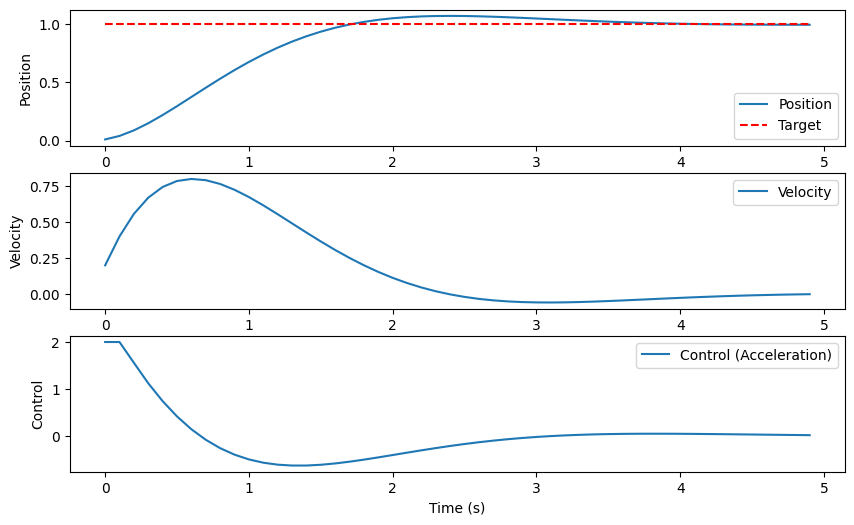

In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

# System parameters
dt = 0.1  # Sampling time
A = np.array([[1, dt], [0, 1]])
B = np.array([[0.5 * dt**2], [dt]])
nx = 2  # Number of states (position, velocity)
nu = 1  # Number of controls (acceleration)

# MPC parameters
N = 10  # Prediction horizon
Q = np.diag([10, 1])  # State cost matrix
R = np.diag([1])      # Control cost matrix
u_max = 2.0           # Maximum control input (acceleration)
x_ref = np.array([1, 0])  # Target state (position=1, velocity=0)

# Initialize simulation
sim_time = 5.0  # Total simulation time
steps = int(sim_time / dt)
x0 = np.array([0, 0])  # Initial state

# Store results
x_hist = np.zeros((nx, steps))
u_hist = np.zeros((nu, steps))
t_hist = np.arange(0, sim_time, dt)

# MPC loop
x_current = x0.copy()
for k in range(steps):
    # Define optimization variables
    x = cp.Variable((nx, N + 1))  # States over horizon
    u = cp.Variable((nu, N))      # Controls over horizon

    # Cost function and constraints
    cost = 0
    constraints = []

    # Initial state constraint
    constraints += [x[:, 0] == x_current]

    for t in range(N):
        # Add state and control cost
        cost += cp.quad_form(x[:, t] - x_ref, Q) + cp.quad_form(u[:, t], R)
        # System dynamics constraint
        constraints += [x[:, t+1] == A @ x[:, t] + B @ u[:, t]]
        # Control input constraints
        constraints += [cp.abs(u[:, t]) <= u_max]

    # Terminal cost (optional)
    cost += cp.quad_form(x[:, N] - x_ref, Q)

    # Solve the optimization problem
    prob = cp.Problem(cp.Minimize(cost), constraints)
    prob.solve(solver=cp.ECOS, verbose=False)

    if prob.status not in ["optimal", "optimal_inaccurate"]:
        print("Solver failed at step", k)
        break

    # Apply the first control input
    u_opt = u[:, 0].value
    x_current = A @ x_current + B @ u_opt

    # Save results
    x_hist[:, k] = x_current
    u_hist[:, k] = u_opt

# Plot results
plt.figure(figsize=(10, 6))
plt.subplot(3, 1, 1)
plt.plot(t_hist, x_hist[0, :], label='Position')
plt.plot([t_hist[0], t_hist[-1]], [x_ref[0], x_ref[0]], 'r--', label='Target')
plt.ylabel('Position')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(t_hist, x_hist[1, :], label='Velocity')
plt.ylabel('Velocity')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(t_hist, u_hist[0, :], label='Control (Acceleration)')
plt.ylabel('Control')
plt.xlabel('Time (s)')
plt.legend()
plt.show()

In [1]:
import pybullet as p
import pybullet_data
import time

# Hubungkan ke simulasi dengan GUI
physicsClient = p.connect(p.GUI)
p.setAdditionalSearchPath(pybullet_data.getDataPath())  # Untuk file URDF seperti plane.urdf

# Set gravitasi (arah ke bawah)
p.setGravity(0, 0, -9.81)

# Muat plane sebagai permukaan
planeId = p.loadURDF("plane.urdf")

# Definisikan properti kotak
box_half_extents = [0.5, 0.5, 0.5]  # setengah ukuran di setiap sumbu (ukuran kotak 1x1x1)
mass = 1.0  # massa kotak
collisionShapeId = p.createCollisionShape(p.GEOM_BOX, halfExtents=box_half_extents)
visualShapeId = p.createVisualShape(p.GEOM_BOX, halfExtents=box_half_extents, rgbaColor=[1, 0, 0, 1])

# Buat badan (multibody) untuk kotak pada posisi awal (0,0,1)
boxId = p.createMultiBody(baseMass=mass,
                          baseCollisionShapeIndex=collisionShapeId,
                          baseVisualShapeIndex=visualShapeId,
                          basePosition=[0, 0, 1])

# Parameter thruster
thruster_force = 20      # besar gaya yang diterapkan (dalam Newton)
thruster_position = [0, 0, -0.5]  # posisi relatif (lokal) pada kotak (misalnya, di bawah kotak)

# Simulasi utama
while True:
    # Dapatkan posisi dan orientasi kotak saat ini
    pos, orn = p.getBasePositionAndOrientation(boxId)
    
    # Hitung posisi thruster dalam koordinat dunia (world frame)
    thruster_world_position = p.multiplyTransforms(pos, orn, thruster_position, [0, 0, 0, 1])[0]

    # Terapkan gaya ke atas (arah [0, 0, 1]) dari posisi thruster di world frame
    p.applyExternalForce(objectUniqueId=boxId,
                         linkIndex=-1,  # -1 berarti pada base (badan utama)
                         forceObj=[0, 0, thruster_force],
                         posObj=thruster_world_position,
                         flags=p.WORLD_FRAME)

    # Langkah simulasi
    p.stepSimulation()
    time.sleep(1./240.)  # Delay agar simulasi berjalan real-time


error: Not connected to physics server.

In [2]:
import pybullet as p
import pybullet_data
import time
import random

# Inisialisasi simulasi dengan GUI
p.connect(p.GUI)
p.resetSimulation()
p.setAdditionalSearchPath(pybullet_data.getDataPath())
p.setGravity(0, 0, -9.81)

# Muat plane sebagai permukaan landing
planeId = p.loadURDF("plane.urdf")

# Tambahkan penanda target landing di (0,0,0)
p.addUserDebugText("TARGET", [0, 0, 0.5], textColorRGB=[0, 1, 0], textSize=2)

# Tentukan posisi awal roket:
# x dan y acak dalam kelipatan 1 meter di rentang -20 hingga 20, z = 100 meter.
init_x = random.choice(range(-20, 21))
init_y = random.choice(range(-20, 21))
init_z = 50

# --- Membuat Model Roket menggunakan MultiBody dengan Fixed Links ---
# Roket memiliki tinggi total 5 meter:
#   - Badan utama: box dengan ukuran 1 m x 1 m x 4 m (half extents: [0.5, 0.5, 2])
#   - Landing legs: box kecil dengan ukuran 0.2 m x 0.2 m x 1 m (half extents: [0.1, 0.1, 0.5])
# Sehingga keseluruhan tinggi: dari (top badan) 2 sampai (bawah landing leg) - (2 + 1) = -3, total = 5 m

# 1. Badan Utama Roket (Base)
base_half_extents = [0.5, 0.5, 2]  # ukuran badan utama
base_collision = p.createCollisionShape(p.GEOM_BOX, halfExtents=base_half_extents)
base_visual = p.createVisualShape(p.GEOM_BOX, halfExtents=base_half_extents, rgbaColor=[1, 0, 0, 1])

# 2. Landing Legs (sebagai links dengan joint fixed)
leg_half_extents = [0.1, 0.1, 0.5]
leg_collision = p.createCollisionShape(p.GEOM_BOX, halfExtents=leg_half_extents)
leg_visual = p.createVisualShape(p.GEOM_BOX, halfExtents=leg_half_extents, rgbaColor=[0, 0, 1, 1])

# Posisi landing legs relatif terhadap pusat badan roket.
# Batas bawah badan utama ada di -base_half_extents[2] = -2.
# Kita posisikan pusat landing leg di: -base_half_extents[2] - leg_half_extents[2] = -2 - 0.5 = -2.5.
leg_z = -base_half_extents[2] - leg_half_extents[2]
# Offset untuk x dan y: base_half_extents[0] + leg_half_extents[0] = 0.5 + 0.1 = 0.6
offset = base_half_extents[0] + leg_half_extents[0]

# Empat landing legs: depan-kanan, depan-kiri, belakang-kanan, belakang-kiri.
linkCollisionShapeIndices = [leg_collision] * 4
linkVisualShapeIndices = [leg_visual] * 4
linkPositions = [
    [ offset,  offset, leg_z],  # depan-kanan
    [-offset,  offset, leg_z],  # depan-kiri
    [ offset, -offset, leg_z],  # belakang-kanan
    [-offset, -offset, leg_z]   # belakang-kiri
]
linkOrientations = [[0, 0, 0, 1]] * 4
linkInertialFramePositions = [[0, 0, 0]] * 4
linkInertialFrameOrientations = [[0, 0, 0, 1]] * 4
linkParentIndices = [0, 0, 0, 0]  # semua landing legs di-attach ke base
linkJointTypes = [p.JOINT_FIXED] * 4
linkJointAxis = [[0, 0, 0]] * 4

mass_base = 50  # Massa badan utama roket (kg)

rocketId = p.createMultiBody(
    baseMass=mass_base,
    baseCollisionShapeIndex=base_collision,
    baseVisualShapeIndex=base_visual,
    basePosition=[init_x, init_y, init_z],
    linkMasses=[0, 0, 0, 0],  # Landing legs dibuat statis (massa 0)
    linkCollisionShapeIndices=linkCollisionShapeIndices,
    linkVisualShapeIndices=linkVisualShapeIndices,
    linkPositions=linkPositions,
    linkOrientations=linkOrientations,
    linkInertialFramePositions=linkInertialFramePositions,
    linkInertialFrameOrientations=linkInertialFrameOrientations,
    linkParentIndices=linkParentIndices,
    linkJointTypes=linkJointTypes,
    linkJointAxis=linkJointAxis
)

# --- Definisi Thruster ---
# Definisikan:
# - Thruster utama: untuk memberikan gaya dorong ke atas, diletakkan mendekati dasar badan utama.
# - Thruster kecil: untuk kontrol arah (kiri, kanan, depan, belakang).

thrusters = {
    "main": {
        "pos": [0, 0, -1.8],   # relatif ke badan utama (sedikit di atas landing legs)
        "force": [0, 0, 1000]   # gaya dorong ke atas (Newton)
    },
    "left": {
        "pos": [-0.6, 0, 0],    # di sisi kiri
        "force": [0, -500, 0]    # gaya untuk mendorong ke arah -Y
    },
    "right": {
        "pos": [0.6, 0, 0],     # di sisi kanan
        "force": [0, 50, 0]     # gaya untuk mendorong ke arah +Y
    },
    "front": {
        "pos": [0, 0.6, 0],     # di sisi depan
        "force": [50, 0, 0]     # gaya untuk mendorong ke arah +X
    },
    "back": {
        "pos": [0, -0.6, 0],    # di sisi belakang
        "force": [-500, 0, 0]    # gaya untuk mendorong ke arah -X
    },
}

# Sembunyikan UI yang tidak diperlukan
p.configureDebugVisualizer(p.COV_ENABLE_GUI, 0)

# --- Simulasi Utama ---
while p.isConnected():
    # Dapatkan posisi dan orientasi roket
    pos, orn = p.getBasePositionAndOrientation(rocketId)
    lin_vel, ang_vel = p.getBaseVelocity(rocketId)
    
    # Terapkan gaya dari thruster utama
    thruster_main_world = p.multiplyTransforms(pos, orn, thrusters["main"]["pos"], [0, 0, 0, 1])[0]
    p.applyExternalForce(
        objectUniqueId=rocketId,
        linkIndex=-1,  # -1 artinya diterapkan pada base
        forceObj=thrusters["main"]["force"],
        posObj=thruster_main_world,
        flags=p.WORLD_FRAME
    )
    
    # Terapkan gaya dari thruster kecil untuk kontrol arah
    for key in ["left", "right", "front", "back"]:
        thruster = thrusters[key]
        thruster_world = p.multiplyTransforms(pos, orn, thruster["pos"], [0, 0, 0, 1])[0]
        p.applyExternalForce(
            objectUniqueId=rocketId,
            linkIndex=-1,
            forceObj=thruster["force"],
            posObj=thruster_world,
            flags=p.WORLD_FRAME
        )
    
    # Update kamera agar mengikuti roket dengan jarak 10 meter
    p.resetDebugVisualizerCamera(
        cameraDistance=100,
        cameraYaw=0,
        cameraPitch=0,
        cameraTargetPosition=[0,0,50]
    )
    
    # Cetak nilai aksi (gaya thruster) dan state observation (posisi, orientasi, kecepatan)
    action_info = f"Main: {thrusters['main']['force']} | Left: {thrusters['left']['force']} | Right: {thrusters['right']['force']} | Front: {thrusters['front']['force']} | Back: {thrusters['back']['force']}"
    state_info = f"Pos: {pos} | Orn: {orn} | LinVel: {lin_vel} | AngVel: {ang_vel}"
    print(f"{action_info} || {state_info}", end="\r")
    
    p.stepSimulation()
    time.sleep(1./240.)


In [1]:
import pybullet as p
import pybullet_data
import time
import random

# Inisialisasi simulasi dengan GUI
p.connect(p.GUI)
p.resetSimulation()
p.setAdditionalSearchPath(pybullet_data.getDataPath())
p.setGravity(0, 0, -9.81)

# Muat plane sebagai permukaan landing
planeId = p.loadURDF("plane.urdf")

# Tambahkan penanda target landing di (0,0,0)
p.addUserDebugText("TARGET", [0, 0, 0.5], textColorRGB=[0, 1, 0], textSize=2)

# Tentukan posisi awal roket:
# x dan y acak dalam kelipatan 1 meter di rentang -20 hingga 20, z = 100 meter.
init_x = random.choice(range(-20, 21))
init_y = random.choice(range(-20, 21))
init_z = 50

# --- Membuat Model Roket ---
# 1. Badan Utama Roket (Tabung Bulat)
body_radius = 0.5  # Radius badan roket
body_height = 4.0  # Tinggi badan roket
body_collision = p.createCollisionShape(p.GEOM_CYLINDER, radius=body_radius, height=body_height)
body_visual = p.createVisualShape(p.GEOM_CYLINDER, radius=body_radius, length=body_height, rgbaColor=[1, 1, 1, 1])  # Putih

# 2. Kerucut di Atas (Nose Cone)
# 2. Kerucut di Atas (Nose Cone) - Menggunakan GEOM_CYLINDER dengan skala berbeda
cone_radius = 0.5  # Radius kerucut
cone_height = 1.0  # Tinggi kerucut
cone_collision = p.createCollisionShape(p.GEOM_CYLINDER, radius=cone_radius, height=cone_height)
cone_visual = p.createVisualShape(p.GEOM_CYLINDER, radius=cone_radius, length=cone_height, rgbaColor=[1, 1, 1, 1])  # Putih

# 3. Landing Legs (Kaki Pendaratan)
leg_half_extents = [0.1, 0.1, 0.5]
leg_collision = p.createCollisionShape(p.GEOM_BOX, halfExtents=leg_half_extents)
leg_visual = p.createVisualShape(p.GEOM_BOX, halfExtents=leg_half_extents, rgbaColor=[0.5, 0.5, 0.5, 1])  # Abu-abu

# Posisi landing legs relatif terhadap pusat badan roket.
leg_z = -body_height / 2 - leg_half_extents[2]
offset = body_radius + leg_half_extents[0]

# Empat landing legs: depan-kanan, depan-kiri, belakang-kanan, belakang-kiri.
linkCollisionShapeIndices = [leg_collision] * 4
linkVisualShapeIndices = [leg_visual] * 4
linkPositions = [
    [offset, offset, leg_z],  # depan-kanan
    [-offset, offset, leg_z],  # depan-kiri
    [offset, -offset, leg_z],  # belakang-kanan
    [-offset, -offset, leg_z]  # belakang-kiri
]
linkOrientations = [[0, 0, 0, 1]] * 4
linkInertialFramePositions = [[0, 0, 0]] * 4
linkInertialFrameOrientations = [[0, 0, 0, 1]] * 4
linkParentIndices = [0, 0, 0, 0]  # semua landing legs di-attach ke base
linkJointTypes = [p.JOINT_FIXED] * 4
linkJointAxis = [[0, 0, 0]] * 4

# Massa badan utama roket (kg)
mass_base = 50

# Buat roket dengan badan utama, kerucut, dan landing legs
rocketId = p.createMultiBody(
    baseMass=mass_base,
    baseCollisionShapeIndex=body_collision,
    baseVisualShapeIndex=body_visual,
    basePosition=[init_x, init_y, init_z],
    linkMasses=[0, 0, 0, 0],  # Landing legs dibuat statis (massa 0)
    linkCollisionShapeIndices=linkCollisionShapeIndices,
    linkVisualShapeIndices=linkVisualShapeIndices,
    linkPositions=linkPositions,
    linkOrientations=linkOrientations,
    linkInertialFramePositions=linkInertialFramePositions,
    linkInertialFrameOrientations=linkInertialFrameOrientations,
    linkParentIndices=linkParentIndices,
    linkJointTypes=linkJointTypes,
    linkJointAxis=linkJointAxis
)

# Tambahkan kerucut di atas badan utama
cone_position = [0, 0, body_height / 2 + cone_height / 2]
cone_orientation = p.getQuaternionFromEuler([0, 0, 0])
p.createMultiBody(
    baseMass=0,  # Kerucut tidak memiliki massa
    baseCollisionShapeIndex=cone_collision,
    baseVisualShapeIndex=cone_visual,
    basePosition=cone_position,
    baseOrientation=cone_orientation
)

# --- Definisi Thruster ---
# Visualisasi thruster
thruster_main_shape = p.createVisualShape(p.GEOM_BOX, halfExtents=[0.2, 0.2, 0.2], rgbaColor=[1, 0, 0, 1])  # Merah
thruster_side_shape = p.createVisualShape(p.GEOM_BOX, halfExtents=[0.1, 0.1, 0.1], rgbaColor=[1, 0.5, 0, 1])  # Orange

# Posisi thruster relatif terhadap badan utama
thrusters = {
    "main": {
        "pos": [0, 0, -body_height / 2],  # Di bawah badan utama
        "force": [0, 0, 400],  # Gaya dorong ke atas (Newton)
        "visual": thruster_main_shape
    },
    "left": {
        "pos": [-body_radius, 0, -body_height / 2 + 0.5],  # Di sisi kiri
        "force": [0, -50, 0],  # Gaya untuk mendorong ke arah -Y
        "visual": thruster_side_shape
    },
    "right": {
        "pos": [body_radius, 0, -body_height / 2 + 0.5],  # Di sisi kanan
        "force": [0, 50, 0],  # Gaya untuk mendorong ke arah +Y
        "visual": thruster_side_shape
    },
    "front": {
        "pos": [0, body_radius, -body_height / 2 + 0.5],  # Di sisi depan
        "force": [50, 0, 0],  # Gaya untuk mendorong ke arah +X
        "visual": thruster_side_shape
    },
    "back": {
        "pos": [0, -body_radius, -body_height / 2 + 0.5],  # Di sisi belakang
        "force": [-50, 0, 0],  # Gaya untuk mendorong ke arah -X
        "visual": thruster_side_shape
    },
}

# Tambahkan visualisasi thruster
for thruster in thrusters.values():
    p.createMultiBody(
        baseMass=0,  # Thruster tidak memiliki massa
        baseCollisionShapeIndex=-1,  # Tidak ada collision shape
        baseVisualShapeIndex=thruster["visual"],
        basePosition=thruster["pos"],
        baseOrientation=[0, 0, 0, 1]
    )

# --- Sensor Kaki Landing ---
# Buat sensor untuk setiap kaki
sensors = []
for i in range(4):
    sensor = p.createCollisionShape(p.GEOM_BOX, halfExtents=[0.1, 0.1, 0.01])  # Sensor tipis
    sensor_pos = linkPositions[i]
    sensor_pos[2] -= leg_half_extents[2]  # Posisi di ujung kaki
    sensor_body = p.createMultiBody(
        baseMass=0,  # Sensor tidak memiliki massa
        baseCollisionShapeIndex=sensor,
        baseVisualShapeIndex=-1,  # Tidak ada visual
        basePosition=sensor_pos,
        baseOrientation=[0, 0, 0, 1]
    )
    sensors.append(sensor_body)

# Sembunyikan UI yang tidak diperlukan
p.configureDebugVisualizer(p.COV_ENABLE_GUI, 0)

# --- Simulasi Utama ---
while p.isConnected():
    # Dapatkan posisi dan orientasi roket
    pos, orn = p.getBasePositionAndOrientation(rocketId)
    lin_vel, ang_vel = p.getBaseVelocity(rocketId)
    
    # Terapkan gaya dari thruster utama
    thruster_main_world = p.multiplyTransforms(pos, orn, thrusters["main"]["pos"], [0, 0, 0, 1])[0]
    p.applyExternalForce(
        objectUniqueId=rocketId,
        linkIndex=-1,  # -1 artinya diterapkan pada base
        forceObj=thrusters["main"]["force"],
        posObj=thruster_main_world,
        flags=p.WORLD_FRAME
    )
    
    # Terapkan gaya dari thruster kecil untuk kontrol arah
    for key in ["left", "right", "front", "back"]:
        thruster = thrusters[key]
        thruster_world = p.multiplyTransforms(pos, orn, thruster["pos"], [0, 0, 0, 1])[0]
        p.applyExternalForce(
            objectUniqueId=rocketId,
            linkIndex=-1,
            forceObj=thruster["force"],
            posObj=thruster_world,
            flags=p.WORLD_FRAME
        )
    
    # Periksa sensor kaki landing
    contact_results = []
    for sensor in sensors:
        contact_points = p.getContactPoints(sensor, planeId)
        if contact_points:
            contact_results.append(True)
        else:
            contact_results.append(False)
    print(f"Kaki Landing: {contact_results}", end="\r")
    
    # Update kamera agar mengikuti roket dengan jarak 10 meter
    p.resetDebugVisualizerCamera(
        cameraDistance=10,
        cameraYaw=0,
        cameraPitch=-30,
        cameraTargetPosition=pos
    )
    
    p.stepSimulation()
    time.sleep(1./240.)

In [1]:
import pybullet as p
import pybullet_data
import time
import random

# Inisialisasi PyBullet dengan GUI dan reset simulasi
p.connect(p.GUI)
p.resetSimulation()
p.setAdditionalSearchPath(pybullet_data.getDataPath())

# Sembunyikan UI yang tidak diperlukan dan aktifkan kontrol kamera dengan mouse
p.configureDebugVisualizer(p.COV_ENABLE_GUI, 0)
p.configureDebugVisualizer(p.COV_ENABLE_SEGMENTATION_MARK_PREVIEW, 0)
p.configureDebugVisualizer(p.COV_ENABLE_DEPTH_BUFFER_PREVIEW, 0)
p.configureDebugVisualizer(p.COV_ENABLE_RGB_BUFFER_PREVIEW, 0)
p.configureDebugVisualizer(p.COV_ENABLE_MOUSE_PICKING, 1)

p.setGravity(0, 0, -9.81)

# Muat plane sebagai permukaan landing
planeId = p.loadURDF("plane.urdf")
p.addUserDebugText("TARGET", [0, 0, 0.5], textColorRGB=[0, 1, 0], textSize=0.5)

# Tentukan posisi awal roket: x dan y acak (kelipatan 1 meter dari -20 hingga 20), z = 100
init_x = random.choice(range(-20, 21))
init_y = random.choice(range(-20, 21))
init_z = 100

# === BUAT MODEL ROKET DENGAN MULTI-BODY ===
# Roket terdiri atas:
#   - Base (badan utama): silinder, tinggi 3 m, radius 0.5, warna putih.
#   - Link 0: Cone (nose), tinggi 2 m, radius 0.5, warna putih, dipasang di atas silinder.
#   - Link 1-4: Landing legs, kotak dengan half extents [0.1, 0.1, 0.25], warna abu-abu,
#                dipasang di sekeliling bagian bawah (bottom silinder ada di -1.5).
#   - Link 5: Thruster utama (visual), kotak dengan half extents [0.1, 0.1, 0.1], warna merah,
#             dipasang tepat di bawah badan (misal, di [0, 0, -1.7]).
#   - Link 6-9: Thruster arah (visual), kotak berwarna oranye, dipasang di kiri, kanan, depan, dan belakang.

# --- Buat shape untuk masing–masing komponen ---
# Base: silinder
base_collision = p.createCollisionShape(p.GEOM_CYLINDER, radius=0.5, height=3.0)
base_visual = p.createVisualShape(p.GEOM_CYLINDER, radius=0.5, length=3.0, rgbaColor=[1, 1, 1, 1])

# Cone: nose
cone_collision = p.createCollisionShape(p.GEOM_CAPSULE, radius=0.5, height=2.0)
cone_visual = p.createVisualShape(p.GEOM_CAPSULE, radius=0.5, length=2.0, rgbaColor=[1,1,1,1])

# Landing leg: kotak
leg_collision = p.createCollisionShape(p.GEOM_BOX, halfExtents=[0.1, 0.1, 0.5])
leg_visual = p.createVisualShape(p.GEOM_BOX, halfExtents=[0.1, 0.1, 0.5], rgbaColor=[0.5, 0.5, 0.5, 1])

# Thruster utama: kotak merah
thruster_main_collision = p.createCollisionShape(p.GEOM_CYLINDER, radius=0.25, height=0.5)
thruster_main_visual = p.createVisualShape(p.GEOM_CYLINDER, radius=0.25, length=0.5, rgbaColor=[1, 0, 0, 1])

# Thruster arah: kotak oranye
thruster_dir_collision = p.createCollisionShape(p.GEOM_BOX, halfExtents=[0.1, 0.1, 0.1])
thruster_dir_visual = p.createVisualShape(p.GEOM_BOX, halfExtents=[0.1, 0.1, 0.1], rgbaColor=[1, 0.5, 0, 1])

# --- Siapkan array untuk link pada multi-body ---
num_links = 10  # Link 0: Cone, 1-4: Landing legs, 5: Thruster utama, 6-9: Thruster arah
linkMasses = [0] * num_links
linkCollisionShapeIndices = []
linkVisualShapeIndices = []
linkPositions = []
linkOrientations = []
linkInertialFramePositions = []
linkInertialFrameOrientations = []
linkParentIndices = []
linkJointTypes = []
linkJointAxis = []

# Link 0: Cone (nose)
# Agar basis cone selaras dengan puncak silinder (silinder berpusat di 0 dengan tinggi 3 m, maka top berada di +1.5).
# Asumsikan pusat cone (secara fisik) terletak pada h/4 dari base; sehingga untuk menyamakan base cone dengan top silinder,
# posisinya diatur menjadi [0, 0, 1.5 + 0.5] = [0, 0, 2.0].
linkCollisionShapeIndices.append(cone_collision)
linkVisualShapeIndices.append(cone_visual)
linkPositions.append([0, 0, 2.0])
linkOrientations.append([0, 0, 0, 1])
linkInertialFramePositions.append([0, 0, 0])
linkInertialFrameOrientations.append([0, 0, 0, 1])
linkParentIndices.append(0)  # langsung terpasang ke base
linkJointTypes.append(p.JOINT_FIXED)
linkJointAxis.append([0, 0, 0])

# Landing legs: Link 1-4
# Bottom silinder berada di -1.5 (karena tinggi silinder 3 m), sehingga pusat landing leg diletakkan di -1.5 - 0.25 = -1.75.
offset = 0.4
leg_z = -1.75

# Link 1: Landing leg depan-kanan
linkCollisionShapeIndices.append(leg_collision)
linkVisualShapeIndices.append(leg_visual)
linkPositions.append([ offset,  offset, leg_z])
linkOrientations.append([0, 0, 0, 1])
linkInertialFramePositions.append([0, 0, 0])
linkInertialFrameOrientations.append([0, 0, 0, 1])
linkParentIndices.append(0)
linkJointTypes.append(p.JOINT_FIXED)
linkJointAxis.append([0, 0, 0])

# Link 2: Landing leg depan-kiri
linkCollisionShapeIndices.append(leg_collision)
linkVisualShapeIndices.append(leg_visual)
linkPositions.append([-offset,  offset, leg_z])
linkOrientations.append([0, 0, 0, 1])
linkInertialFramePositions.append([0, 0, 0])
linkInertialFrameOrientations.append([0, 0, 0, 1])
linkParentIndices.append(0)
linkJointTypes.append(p.JOINT_FIXED)
linkJointAxis.append([0, 0, 0])

# Link 3: Landing leg belakang-kanan
linkCollisionShapeIndices.append(leg_collision)
linkVisualShapeIndices.append(leg_visual)
linkPositions.append([ offset, -offset, leg_z])
linkOrientations.append([0, 0, 0, 1])
linkInertialFramePositions.append([0, 0, 0])
linkInertialFrameOrientations.append([0, 0, 0, 1])
linkParentIndices.append(0)
linkJointTypes.append(p.JOINT_FIXED)
linkJointAxis.append([0, 0, 0])

# Link 4: Landing leg belakang-kiri
linkCollisionShapeIndices.append(leg_collision)
linkVisualShapeIndices.append(leg_visual)
linkPositions.append([-offset, -offset, leg_z])
linkOrientations.append([0, 0, 0, 1])
linkInertialFramePositions.append([0, 0, 0])
linkInertialFrameOrientations.append([0, 0, 0, 1])
linkParentIndices.append(0)
linkJointTypes.append(p.JOINT_FIXED)
linkJointAxis.append([0, 0, 0])

# Thruster utama (visual): Link 5, ditempatkan di bawah badan, misal di [0, 0, -1.7]
linkCollisionShapeIndices.append(thruster_main_collision)
linkVisualShapeIndices.append(thruster_main_visual)
linkPositions.append([0, 0, -1.7])
linkOrientations.append([0, 0, 0, 1])
linkInertialFramePositions.append([0, 0, 0])
linkInertialFrameOrientations.append([0, 0, 0, 1])
linkParentIndices.append(0)
linkJointTypes.append(p.JOINT_FIXED)
linkJointAxis.append([0, 0, 0])

# Thruster arah (visual): Links 6-9
# Link 6: Thruster kiri, posisinya di [-0.5, 0, 0]
linkCollisionShapeIndices.append(thruster_dir_collision)
linkVisualShapeIndices.append(thruster_dir_visual)
linkPositions.append([-0.5, 0, -1.0])
linkOrientations.append([0, 0, 0, 1])
linkInertialFramePositions.append([0, 0, 0])
linkInertialFrameOrientations.append([0, 0, 0, 1])
linkParentIndices.append(0)
linkJointTypes.append(p.JOINT_FIXED)
linkJointAxis.append([0, 0, 0])

# Link 7: Thruster kanan, di [0.5, 0, 0]
linkCollisionShapeIndices.append(thruster_dir_collision)
linkVisualShapeIndices.append(thruster_dir_visual)
linkPositions.append([0.5, 0, -1.0])
linkOrientations.append([0, 0, 0, 1])
linkInertialFramePositions.append([0, 0, 0])
linkInertialFrameOrientations.append([0, 0, 0, 1])
linkParentIndices.append(0)
linkJointTypes.append(p.JOINT_FIXED)
linkJointAxis.append([0, 0, 0])

# Link 8: Thruster depan, di [0, 0.5, 0]
linkCollisionShapeIndices.append(thruster_dir_collision)
linkVisualShapeIndices.append(thruster_dir_visual)
linkPositions.append([0, 0.5, -1.0])
linkOrientations.append([0, 0, 0, 1])
linkInertialFramePositions.append([0, 0, 0])
linkInertialFrameOrientations.append([0, 0, 0, 1])
linkParentIndices.append(0)
linkJointTypes.append(p.JOINT_FIXED)
linkJointAxis.append([0, 0, 0])

# Link 9: Thruster belakang, di [0, -0.5, 0]
linkCollisionShapeIndices.append(thruster_dir_collision)
linkVisualShapeIndices.append(thruster_dir_visual)
linkPositions.append([0, -0.5, -1.0])
linkOrientations.append([0, 0, 0, 1])
linkInertialFramePositions.append([0, 0, 0])
linkInertialFrameOrientations.append([0, 0, 0, 1])
linkParentIndices.append(0)
linkJointTypes.append(p.JOINT_FIXED)
linkJointAxis.append([0, 0, 0])

# Buat multi-body roket
rocketId = p.createMultiBody(
    baseMass=100,  # massa badan utama
    baseCollisionShapeIndex=base_collision,
    baseVisualShapeIndex=base_visual,
    basePosition=[init_x, init_y, init_z],
    baseOrientation=[0, 0, 0, 1],
    linkMasses=linkMasses,
    linkCollisionShapeIndices=linkCollisionShapeIndices,
    linkVisualShapeIndices=linkVisualShapeIndices,
    linkPositions=linkPositions,
    linkOrientations=linkOrientations,
    linkInertialFramePositions=linkInertialFramePositions,
    linkInertialFrameOrientations=linkInertialFrameOrientations,
    linkParentIndices=linkParentIndices,
    linkJointTypes=linkJointTypes,
    linkJointAxis=linkJointAxis
)

# === Definisikan Thruster Fisik ===
# Gaya yang akan diterapkan pada badan roket (base) menggunakan koordinat lokal (p.LINK_FRAME)
thrusters = {
    "main": {
        "pos": [0, 0, -1.7],   # posisi di base (sama dengan thruster utama visual)
        "force": [0, 0, 10000]
    },
    "left": {
        "pos": [-0.5, 0, 0],
        "force": [0, -1000, 0]
    },
    "right": {
        "pos": [0.5, 0, 0],
        "force": [0, 1000, 0]
    },
    "front": {
        "pos": [0, 0.5, 0],
        "force": [1000, 0, 0]
    },
    "back": {
        "pos": [0, -0.5, 0],
        "force": [-1000, 0, 0]
    },
}

# === SIMULASI UTAMA ===
while p.isConnected():
    # Terapkan gaya thruster (dalam frame lokal, sehingga orientasi gaya mengikuti orientasi roket)
    for key, thruster in thrusters.items():
        p.applyExternalForce(
            objectUniqueId=rocketId,
            linkIndex=-1,  # terapkan pada base
            forceObj=thruster["force"],
            posObj=thruster["pos"],
            flags=p.LINK_FRAME
        )
    
    # Ambil state observation dari badan roket
    pos, orn = p.getBasePositionAndOrientation(rocketId)
    lin_vel, ang_vel = p.getBaseVelocity(rocketId)
    
    # Cek sensor pada setiap landing leg (link 1-4)
    sensor_states = {}
    for leg_index in [1, 2, 3, 4]:
        contacts = p.getContactPoints(bodyA=rocketId, bodyB=planeId, linkIndexA=leg_index)
        sensor_states[f"leg_{leg_index}"] = (len(contacts) > 0)
    
    action_info = (f"Actions: Main {thrusters['main']['force']}, Left {thrusters['left']['force']}, "
                   f"Right {thrusters['right']['force']}, Front {thrusters['front']['force']}, "
                   f"Back {thrusters['back']['force']}")
    state_info = (f"State: Pos {pos}, Orn {orn}, LinVel {lin_vel}, AngVel {ang_vel}, Sensors {sensor_states}")
    
    print(f"{action_info} || {state_info}", end="\r")
    
    p.resetDebugVisualizerCamera(
        cameraDistance=10,
        cameraYaw=0,
        cameraPitch=-30,
        cameraTargetPosition=pos
    )
    
    p.stepSimulation()
    time.sleep(1./1000.)


In [1]:
import numpy as np
import cvxpy as cp

# --- Utility: PID Class ---
class PID:
    def __init__(self, kp, ki, kd, dt, integrator_limit=np.inf):
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.dt = dt
        self.integrator = 0.0
        self.prev_error = 0.0
        self.integrator_limit = integrator_limit

    def update(self, error):
        self.integrator += error * self.dt
        self.integrator = np.clip(self.integrator, -self.integrator_limit, self.integrator_limit)
        derivative = (error - self.prev_error) / self.dt
        self.prev_error = error
        return self.kp * error + self.ki * self.integrator + self.kd * derivative

# ================================
# 1. PID Controller (Multi-Parameter)
# ================================
class PIDController:
    def __init__(self, dt, mass, g, u_max):
        self.dt = dt
        self.mass = mass
        self.g = g
        self.u_max = u_max

        # PID untuk altitude (state: [z, vz])
        self.alt_pid = PID(kp=50, ki=0.5, kd=20, dt=dt, integrator_limit=10)
        # PID untuk attitude: masing-masing untuk roll dan pitch
        self.roll_pid = PID(kp=30, ki=0.2, kd=10, dt=dt, integrator_limit=5)
        self.pitch_pid = PID(kp=30, ki=0.2, kd=10, dt=dt, integrator_limit=5)
        # Koefisien untuk mengonversi error horizontal ke desired attitude
        self.k_x = 0.01
        self.k_y = 0.01

    def compute_control(self, obs):
        # State: [x, y, z, roll, pitch, yaw, vx, vy, vz, ang_vel_x, ang_vel_y, ang_vel_z]
        x, y, z = obs[0:3]
        roll, pitch, yaw = obs[3:6]
        vx, vy, vz = obs[6:9]
        ang_vel_x, ang_vel_y, ang_vel_z = obs[9:12]

        # Horizontal: target posisi (0,0) menghasilkan desired attitude
        error_x = -x
        error_y = -y
        desired_pitch = -self.k_x * error_x  # note: untuk percepatan ke +x, diinginkan pitch negatif
        desired_roll  = self.k_y * error_y

        # Altitude control (PID)
        error_z = -z
        F_total = self.alt_pid.update(error_z) + self.mass * self.g
        F_total = max(F_total, 0)

        # Attitude control (PID) untuk melacak desired attitude
        error_pitch = desired_pitch - pitch
        error_roll  = desired_roll  - roll
        M_x = self.pitch_pid.update(error_pitch)   # Momen untuk mengatur pitch (sumbu x)
        M_y = self.roll_pid.update(error_roll)       # Momen untuk mengatur roll  (sumbu y)

        # --- Control Allocation ---
        u_avg = F_total / 4.0
        u1 = u_avg - 0.5 * (M_y / 0.3)
        u2 = u_avg - 0.5 * (M_x / 0.3)
        u3 = u_avg + 0.5 * (M_y / 0.3)
        u4 = u_avg + 0.5 * (M_x / 0.3)
        # Saturasi tiap thruster
        u1 = np.clip(u1, 0, self.u_max)
        u2 = np.clip(u2, 0, self.u_max)
        u3 = np.clip(u3, 0, self.u_max)
        u4 = np.clip(u4, 0, self.u_max)
        # Normalisasi ke range [-1, 1] (asumsi env akan mengalikan dengan max_thrust)
        action = np.array([u1, u2, u3, u4]) / self.u_max
        action = 2 * action - 1
        return action

# ================================
# 2. LQR Controller (Multi-Parameter)
# ================================
class LQRController:
    def __init__(self, dt, mass, g, u_max):
        self.dt = dt
        self.mass = mass
        self.g = g
        self.u_max = u_max
        # Gain untuk altitude: [error_z, error_vz]
        self.K_alt = np.array([80, 20])
        # Gain untuk attitude: [error, error_rate]
        self.K_pitch = np.array([40, 10])  # untuk pitch (sumbu x)
        self.K_roll  = np.array([40, 10])  # untuk roll  (sumbu y)
        # Koefisien horizontal
        self.k_x = 0.01
        self.k_y = 0.01

    def compute_control(self, obs):
        x, y, z = obs[0:3]
        roll, pitch, yaw = obs[3:6]
        vx, vy, vz = obs[6:9]
        ang_vel_x, ang_vel_y, ang_vel_z = obs[9:12]

        # Desired attitude berdasarkan error horizontal
        error_x = -x
        error_y = -y
        desired_pitch = -self.k_x * error_x
        desired_roll  = self.k_y * error_y

        # Altitude control (LQR-like)
        error_z = -z
        error_vz = -vz
        F_total = np.dot(self.K_alt, np.array([error_z, error_vz])) + self.mass * self.g
        F_total = max(F_total, 0)

        # Attitude control (LQR-like)
        error_pitch = desired_pitch - pitch
        error_roll  = desired_roll - roll
        # Asumsikan target angular rate = 0
        M_x = np.dot(self.K_pitch, np.array([error_pitch, -ang_vel_y]))
        M_y = np.dot(self.K_roll,  np.array([error_roll,  -ang_vel_x]))

        # --- Control Allocation ---
        u_avg = F_total / 4.0
        u1 = u_avg - 0.5 * (M_y / 0.3)
        u2 = u_avg - 0.5 * (M_x / 0.3)
        u3 = u_avg + 0.5 * (M_y / 0.3)
        u4 = u_avg + 0.5 * (M_x / 0.3)
        u1 = np.clip(u1, 0, self.u_max)
        u2 = np.clip(u2, 0, self.u_max)
        u3 = np.clip(u3, 0, self.u_max)
        u4 = np.clip(u4, 0, self.u_max)
        action = np.array([u1, u2, u3, u4]) / self.u_max
        action = 2 * action - 1
        return action

# ================================
# 3. MPC Controller (Multi-Parameter)
# ================================
class MPCController:
    def __init__(self, dt, mass, g, u_max, horizon=10):
        self.dt = dt
        self.mass = mass
        self.g = g
        self.u_max = u_max
        self.horizon = horizon
        # Asumsi momen inersia (sederhana)
        self.Ixx = 0.3  # untuk roll
        self.Iyy = 0.3  # untuk pitch
        # Koefisien horizontal
        self.k_x = 0.01
        self.k_y = 0.01
        # Bobot pada cost function (bisa di-tuning)
        self.w_alt = 1.0
        self.w_vz  = 0.1
        self.w_att = 1.0
        self.w_rate = 0.1
        self.w_input = 0.001

    def compute_control(self, obs):
        # Ekstrak state
        x, y, z = obs[0:3]
        roll, pitch, yaw = obs[3:6]
        vx, vy, vz = obs[6:9]
        ang_vel_x, ang_vel_y, ang_vel_z = obs[9:12]
        # Desired attitude dari error horizontal
        error_x = -x
        error_y = -y
        desired_pitch = -self.k_x * error_x
        desired_roll  = self.k_y * error_y

        N = self.horizon
        dt = self.dt

        # --- Variabel optimasi untuk Altitude ---
        F = cp.Variable(N)
        z_var = cp.Variable(N+1)
        vz_var = cp.Variable(N+1)
        # --- Variabel optimasi untuk Roll (attitude) ---
        M_y = cp.Variable(N)
        roll_var = cp.Variable(N+1)
        roll_rate = cp.Variable(N+1)
        # --- Variabel optimasi untuk Pitch (attitude) ---
        M_x = cp.Variable(N)
        pitch_var = cp.Variable(N+1)
        pitch_rate = cp.Variable(N+1)

        cost = 0
        constraints = []
        # Kondisi awal:
        constraints += [z_var[0] == z, vz_var[0] == vz]
        constraints += [roll_var[0] == roll, roll_rate[0] == ang_vel_x]   # gunakan ang_vel_x sebagai laju roll
        constraints += [pitch_var[0] == pitch, pitch_rate[0] == ang_vel_y]  # gunakan ang_vel_y sebagai laju pitch

        for k in range(N):
            # Dinamika altitude:
            constraints += [z_var[k+1] == z_var[k] + dt * vz_var[k]]
            constraints += [vz_var[k+1] == vz_var[k] + dt * (F[k] / self.mass - self.g)]
            # Dinamika roll:
            constraints += [roll_var[k+1] == roll_var[k] + dt * roll_rate[k]]
            constraints += [roll_rate[k+1] == roll_rate[k] + dt * (M_y[k] / self.Ixx)]
            # Dinamika pitch:
            constraints += [pitch_var[k+1] == pitch_var[k] + dt * pitch_rate[k]]
            constraints += [pitch_rate[k+1] == pitch_rate[k] + dt * (M_x[k] / self.Iyy)]
            # Cost untuk altitude:
            cost += self.w_alt * cp.square(z_var[k+1]) + self.w_vz * cp.square(vz_var[k+1])
            # Cost untuk attitude: usahakan roll dan pitch mendekati desired
            cost += self.w_att * cp.square(roll_var[k+1] - desired_roll) + self.w_rate * cp.square(roll_rate[k+1])
            cost += self.w_att * cp.square(pitch_var[k+1] - desired_pitch) + self.w_rate * cp.square(pitch_rate[k+1])
            # Biaya penggunaan input:
            cost += self.w_input * (cp.square(F[k]) + cp.square(M_x[k]) + cp.square(M_y[k]))
            # Batas input: F di antara 0 dan 4*u_max (karena total gaya dari 4 thruster)
            constraints += [F[k] >= 0, F[k] <= 4 * self.u_max]
        prob = cp.Problem(cp.Minimize(cost), constraints)
        prob.solve(solver=cp.OSQP, warm_start=True)

        if F.value is None or M_x.value is None or M_y.value is None:
            F0 = self.mass * self.g
            M_x0 = 0
            M_y0 = 0
        else:
            F0 = F.value[0]
            M_x0 = M_x.value[0]
            M_y0 = M_y.value[0]

        # --- Control Allocation ---
        u_avg = F0 / 4.0
        u1 = u_avg - 0.5 * (M_y0 / 0.3)
        u2 = u_avg - 0.5 * (M_x0 / 0.3)
        u3 = u_avg + 0.5 * (M_y0 / 0.3)
        u4 = u_avg + 0.5 * (M_x0 / 0.3)
        u1 = np.clip(u1, 0, self.u_max)
        u2 = np.clip(u2, 0, self.u_max)
        u3 = np.clip(u3, 0, self.u_max)
        u4 = np.clip(u4, 0, self.u_max)
        action = np.array([u1, u2, u3, u4]) / self.u_max
        action = 2 * action - 1
        return action


In [4]:
import gymnasium as gym
import time
from LunarLander3DEnv.envs import LunarLander3DEnv  # Pastikan environment sudah terdaftar (register)

# Asumsi parameter sistem (sesuai URDF yang diberikan)
mass = 31.25      # kg
g = 9.81          # m/s^2
u_max = 150.0     # maksimum gaya per thruster (N)
dt = 1/240.0      # timestep (sesuai render_fps=240)

# Pilih metode kontrol: "PID", "LQR", atau "MPC"
controller_type = "LQR"  # ganti sesuai keinginan

if controller_type == "PID":
    controller = PIDController(dt, mass, g, u_max)
elif controller_type == "LQR":
    controller = LQRController(dt, mass, g, u_max)
elif controller_type == "MPC":
    controller = MPCController(dt, mass, g, u_max, horizon=10)
else:
    raise ValueError("Jenis controller tidak dikenal!")

# Buat environment
env = gym.make("LunarLander3DEnv-v0", render_mode="human")
obs, info = env.reset()

done = False
while not done:
    # Controller menghitung aksi berdasarkan observasi
    action = controller.compute_control(obs)
    obs, reward, terminated, truncated, info = env.step(action)
    done = truncated
    if terminated:
        obs, info = env.reset()
    time.sleep(1.0/240.0)

env.close()


error: Not connected to physics server.

In [8]:
import gymnasium as gym
import time
from stable_baselines3 import PPO


# Buat environment
env = gym.make("LunarLander", render_mode="human")

# Buat model PPO
model = PPO("MlpPolicy", env, verbose=1)

# Latih model selama 10000 episode
model.learn(total_timesteps=10000)

# Simulasikan model selama 100 episode
obs, info= env.reset()
for _ in range(100):
    action, _ = model.predict(obs)
    obs, reward, done, info = env.step(action)
    time.sleep(1.0/60.0)
    if done:
        obs = env.reset()

env.close()





c:\Users\User\anaconda3\envs\robot_sim\lib\site-packages\gymnasium\envs\registration.py:521: UserWarning: WARN: Using the latest versioned environment `LunarLander-v2` instead of the unversioned environment `LunarLander`.
  logger.warn(
c:\Users\User\anaconda3\envs\robot_sim\lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


KeyboardInterrupt: 